In [107]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
# from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [108]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
        statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

    filename = maybe_download('text8.zip', 31344016)

In [109]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [110]:
def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [160]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'term', 'anarchism', 'term', 'originated', 'of', 'as']


In [161]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))

    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    print(vocabulary_size, embedding_size)


    embeddings_plot = tf.Print(embeddings, [embeddings], "Plot embeddings")
    softmax_weights_plot = tf.Print(softmax_weights, [softmax_weights], "Plot embeddings")

    # Model.
    # Look up embeddings for inputs.
    print(embeddings, train_dataset)
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    print(embed)
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    print(similarity)

50000 128
<tf.Variable 'Variable:0' shape=(50000, 128) dtype=float32_ref> Tensor("Placeholder:0", shape=(128,), dtype=int32, device=/device:CPU:0)
Tensor("embedding_lookup:0", shape=(128, 128), dtype=float32, device=/device:CPU:0)
Tensor("MatMul:0", shape=(16, 50000), dtype=float32, device=/device:CPU:0)


In [168]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        #     print(batch_data, batch_labels)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
#     print(session.run(embeddings_plot))
#     print(session.run(softmax_weights_plot))
    
    
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.649592
Nearest to with: passion, songhai, brussel, craps, arrhythmias, overcrowded, cairns, priced,
Nearest to had: hugs, canned, residency, keyword, hammers, inaugural, ballots, feat,
Nearest to use: turbo, freer, shamanistic, sorcery, carousel, hellenes, protections, maja,
Nearest to b: lorna, uterine, contralto, microbats, incompatible, faceless, rampant, roamed,
Nearest to system: conqueror, yielded, globalization, sepia, sociologists, insisting, ribosome, origen,
Nearest to more: nasal, crank, disarray, reginald, rewrites, leucine, becomes, stepmother,
Nearest to d: shelf, brindisi, underscore, mim, royale, blatant, candida, spoiling,
Nearest to time: gustaf, gordon, italics, malm, denver, intercommunal, hudsucker, chill,
Nearest to UNK: domed, juveniles, cameroons, governance, along, photorealistic, indicate, walken,
Nearest to a: calamine, overhauled, pastors, mohandas, ursinus, siege, genocide, where,
Nearest to at: homily, archers, mints, 

Average loss at step 52000: 3.430474
Average loss at step 54000: 3.460704
Average loss at step 56000: 3.453893
Average loss at step 58000: 3.443311
Average loss at step 60000: 3.409400
Nearest to with: between, kowtow, dimensionally, against, vehemently, tynwald, passion, in,
Nearest to had: has, have, was, were, having, been, since, ruhollah,
Nearest to use: form, sense, tauris, abated, reduce, rsync, prevention, way,
Nearest to b: r, c, f, y, uterine, stine, volt, cathedrals,
Nearest to system: systems, conqueror, calculator, insisting, buggery, vulpes, cpl, organisation,
Nearest to more: less, most, rather, very, larger, smaller, cucurbitaceae, delayed,
Nearest to d: shelf, teaser, jabberwocky, gerard, et, roy, o, pops,
Nearest to time: year, carradine, waylon, nearest, case, acker, barrows, intercommunal,
Nearest to UNK: k, http, ba, q, iec, bitwise, ping, uploading,
Nearest to a: any, the, another, succulent, no, isolating, identifier, toxins,
Nearest to at: under, during, from, i

In [169]:
print(batch_labels.shape)
print(len(set(data)))

(128, 1)
50000


In [170]:
batch_data, batch_labels

(array([  395,   395,    45,    45,  2327,  2327,  4555,  4555,  5761,
         5761,    35,    35,   484,   484,  2543,  2543,   395,   395,
          531,   531,    26,    26,   417,   417,   522,   522,  1207,
         1207,    12,    12,  2603,  2603,  1936,  1936,     6,     6,
        30826, 30826,    35,    35,  9801,  9801,  2543,  2543,  3146,
         3146,    63,    63,   320,   320,    74,    74,   148,   148,
         2176,  2176,    32,    32,    95,    95,    62,    62,  4115,
         4115,    35,    35,  1596,  1596,   105,   105,  2543,  2543,
           11,    11,  3531,  3531,    12,    12,    27,    27,    11,
           11,     6,     6,  1340,  1340,    25,    25,  1596,  1596,
           12,    12,   185,   185,    12,    12,    27,    27,    11,
           11,    38,    38,  2603,  2603,     7,     7,     6,     6,
          284,   284,   223,   223,    17,    17,  4720,  4720,    79,
           79,    17,    17,  4108,  4108,     2,     2,     1,     1,
      

In [173]:
data[0]
# count
# len(count)
# dictionary
reverse_dictionary[5234]

'anarchism'

In [174]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

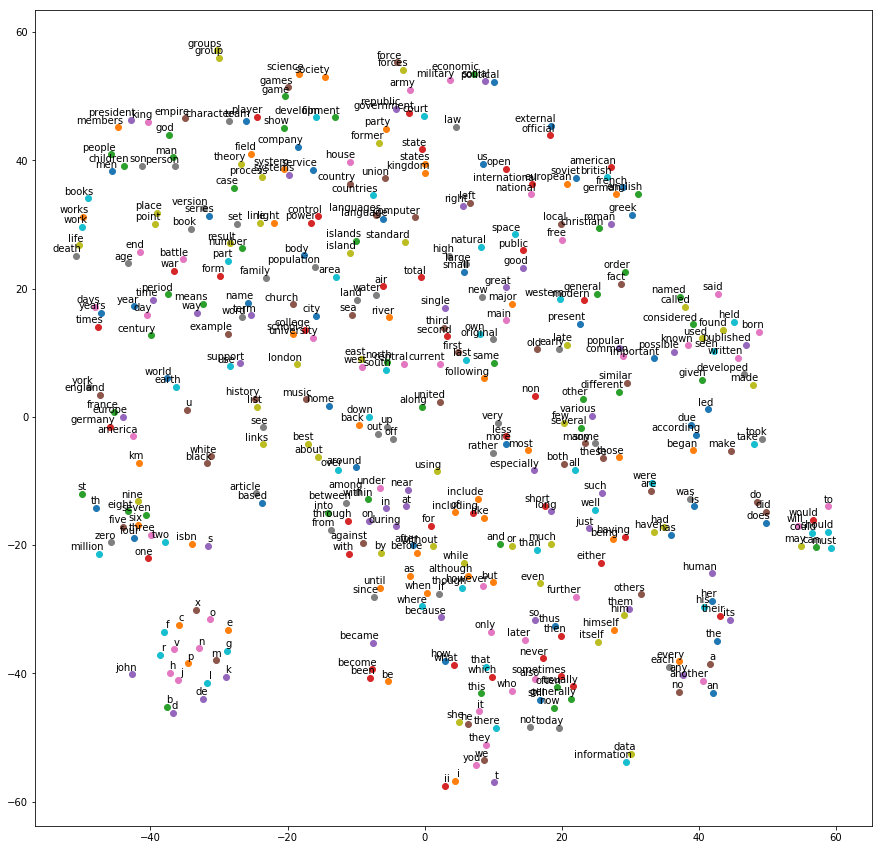

In [175]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [176]:
#CBOW
def generates_batch_cbow(batch_size, context_window):
    # all context tokens should be used, hence no associated num_skips argument
    global data_index
    context_size = 2 * context_window
    batch = np.ndarray(shape=(batch_size, context_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * context_window + 1  # [ context_window target context_window ]
    buffer = collections.deque(maxlen=span)
  
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        # context tokens are just all the tokens in buffer except the target
#         print(buffer)
        batch[i, :] = [token for idx, token in enumerate(buffer) if idx != context_window]
        labels[i, 0] = buffer[context_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('CBOW')
print('data:', [reverse_dictionary[di] for di in data[:8]])

for skip_window in (2, 4):
    data_index = 0
    batch, labels = generates_batch_cbow(batch_size=1, context_window=skip_window)
    print('\n skip_window = {}:'.format(skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch.reshape(2 * skip_window)])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(1)])

CBOW
data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

 skip_window = 2:
    batch: ['anarchism', 'originated', 'a', 'term']
    labels: ['as']

 skip_window = 4:
    batch: ['anarchism', 'originated', 'as', 'a', 'of', 'abuse', 'first', 'used']
    labels: ['term']


In [177]:
batch1, labels1 = generates_batch_cbow(2, 2)
batch1, labels1
# data_index

(array([[  128,   742, 10572,   134],
        [  742,   477,   134,     1]]), array([[  477],
        [10572]]))

In [180]:
#CBOW
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.
context_size = 2 * skip_window

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, context_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))

    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    print(vocabulary_size, embedding_size)
    
    
    embeddings_plot = tf.Print(embeddings, [embeddings], "Plot embeddings")
    softmax_weights_plot = tf.Print(softmax_weights, [softmax_weights], "Plot embeddings")
    
    # Model.
    # Look up embeddings for inputs.
    print(embeddings, train_dataset)
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    print(embed)
    
    embed_context = tf.reduce_mean(embed, 1)
    
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_context,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    print(similarity)

50000 128
<tf.Variable 'Variable:0' shape=(50000, 128) dtype=float32_ref> Tensor("Placeholder:0", shape=(128, 2), dtype=int32, device=/device:CPU:0)
Tensor("embedding_lookup:0", shape=(128, 2, 128), dtype=float32, device=/device:CPU:0)
Tensor("MatMul:0", shape=(16, 50000), dtype=float32, device=/device:CPU:0)


In [182]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generates_batch_cbow(
          batch_size, skip_window)
        #     print(batch_data, batch_labels)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
#     print(session.run(embeddings_plot))
#     print(session.run(softmax_weights_plot))
    
    
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 6.786771
Nearest to first: wolfe, metastability, doe, petrograd, monad, unilateral, dryope, callet,
Nearest to has: tangled, unusual, breakbeats, monasteries, carolyn, alcs, holiness, rig,
Nearest to from: plissken, pappus, catalyze, tor, goi, wolf, austral, algiers,
Nearest to s: jiangxi, ict, fulfilled, ateneo, jovi, tease, protruding, uneconomic,
Nearest to but: kb, priestley, poee, scrooge, frieza, ryaku, suggestive, rebekah,
Nearest to can: changeover, unconquered, khmer, gohan, gifted, warmly, ment, blount,
Nearest to is: derby, abingdon, ron, procedural, argumentum, hizballah, nozzle, duet,
Nearest to its: tartu, ordinated, timing, durch, holocene, macroevolution, tame, whilst,
Nearest to d: shao, twa, unprepared, vientiane, novelties, gylfaginning, lapsed, stg,
Nearest to a: pointy, lewes, idiomatic, carrying, rationalists, thick, muon, mace,
Nearest to new: eldridge, fangio, har, synagogue, industrialized, edwina, firewood, hearst,
Nearest t

Average loss at step 52000: 2.881270
Average loss at step 54000: 2.861724
Average loss at step 56000: 2.856089
Average loss at step 58000: 2.755734
Average loss at step 60000: 2.822277
Nearest to first: last, second, next, final, eighth, third, aft, leverett,
Nearest to has: had, have, is, was, provides, having, refers, requires,
Nearest to from: into, through, pappus, catalyze, anagram, ries, in, explosively,
Nearest to s: isbn, mccormick, larvae, geographer, whose, his, lesley, jaffna,
Nearest to but: however, and, although, flavours, which, though, churning, dotted,
Nearest to can: could, may, will, must, would, should, cannot, might,
Nearest to is: was, has, are, be, does, seems, appears, exists,
Nearest to its: their, his, her, the, lasers, my, unomig, your,
Nearest to d: b, rationality, l, mcpherson, twa, beak, v, unselfish,
Nearest to a: any, another, thunderball, the, every, relatively, falkirk, ioan,
Nearest to new: cannibal, flock, particular, individuality, arian, hearst, pa

In [184]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

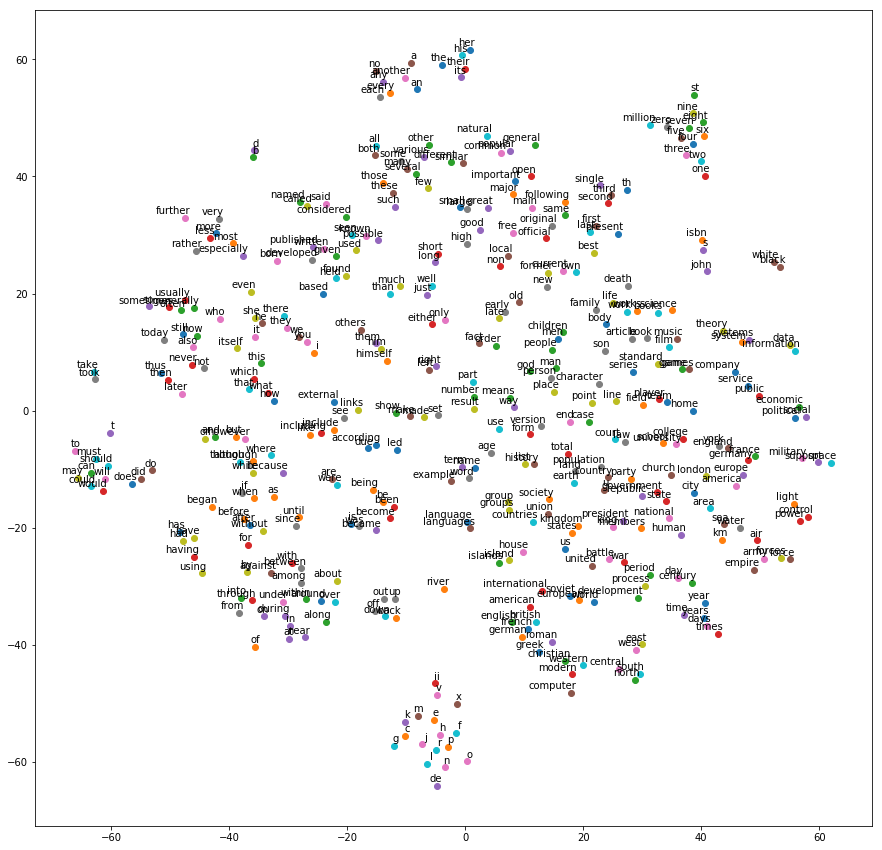

In [185]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)